# TOXIC COMMENT CLASSIFICATION PART 2 
cont.. from  Comment Classification initial overview and EDA

Here we'll revisit the information extracted from PART 1 of our analysis and see how we can use it in model building

In [1]:
getwd()

[1] "C:/Users/sugand1994/Downloads"

In [2]:
#list of libraries required
library(tm)
library(SnowballC)
library(dplyr)
library(ggplot2)
library(rpart)
library(tidyr)
library(tidytext)
library(textstem)

Loading required package: NLP
Loading required package: RColorBrewer

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



In [3]:
train <- read.csv('comment.train.csv', stringsAsFactors=FALSE )

In [4]:
dim(train)

[1] 159571      8

In [5]:
str(train)

'data.frame':	159571 obs. of  8 variables:
 $ id           : chr  "0000997932d777bf" "000103f0d9cfb60f" "000113f07ec002fd" "0001b41b1c6bb37e" ...
 $ comment_text : chr  "Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms"| __truncated__ "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)" "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information"| __truncated__ "\"\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be lat"| __truncated__ ...
 $ toxic        : int  0 0 0 0 0 0 1 0 0 0 ...
 $ severe_toxic : int  0 0 0 0 0 0 1 0 0 0 ...
 $ obscene      : int  0 0 0 0 0 0 1 0 0 0 ...
 $ threat       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ insult       : int  0 0 0 0 0 0 1 0 0 0 ...
 $ identity_hate: int  0 0 0 0 0 0 0 0 0 0 ...


In [6]:
test <- read.csv('commtest.csv', stringsAsFactors=FALSE )

In [7]:
str(test)

'data.frame':	153164 obs. of  2 variables:
 $ id          : chr  "00001cee341fdb12" "0000247867823ef7" "00013b17ad220c46" "00017563c3f7919a" ...
 $ comment_text: chr  "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should"| __truncated__ "== From RfC == \n\n The title is fine as it is, IMO." "\" \n\n == Sources == \n\n * Zawe Ashton on Lapland â€”  /  \"" ":If you have a look back at the source, the information I updated was the correct form. I can only guess the so"| __truncated__ ...


In [8]:
target <- read.csv('commsample_submission.csv')

In [9]:
str(target)

'data.frame':	153164 obs. of  7 variables:
 $ id           : Factor w/ 153164 levels "00001cee341fdb12",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ toxic        : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ severe_toxic : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ obscene      : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ threat       : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ insult       : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ identity_hate: num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...


In [10]:
#now lets merge the target and test data by 'id' for our further analysis
test <- merge(test,target, by = 'id' )

In [11]:
colnames(test)

[1] "id"            "comment_text"  "toxic"         "severe_toxic" 
[5] "obscene"       "threat"        "insult"        "identity_hate"

In [12]:
#now let's create a complete dataset for text cleaning and create a document term matrix and later let's split it.
comment <- rbind(train, test)

In [13]:
comment$comment_text <- sapply(comment$comment_text,tolower)
comment$comment_text = iconv(comment$comment_text, 'UTF-8', 'ASCII') # to remove EMOTICONS 

In [14]:
removeSpecialChars <- function(x) gsub("[^a-zA-Z0-9 ]", " ", x)

In [15]:
#custom fucntion to fix the contractions
fix.contractions <- function(doc) {
  # "won't" is a special case as it does not expand to "wo not"
  doc <- gsub("won't", "will not", doc)
  doc <- gsub("can't", "can not", doc)
  doc <- gsub("n't", " not", doc)
  doc <- gsub("'ll", " will", doc)
  doc <- gsub("'re", " are", doc)
  doc <- gsub("'ve", " have", doc)
  doc <- gsub("'m", " am", doc)
  doc <- gsub("'d", " would", doc)
  # 's could be 'is' or could be possessive: it has no expansion
  doc <- gsub("'s", "", doc)
  return(doc)
 }

In [16]:
comment$comment_text <- sapply(comment$comment_text, fix.contractions)
comment$comment_text <- sapply(comment$comment_text, removeSpecialChars)


In [17]:
# described in part1, now to proceed further we lemmatize the strings.
#Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words,
#normally aiming to remove inflectional endings only and to return the base or dictionary form of a word,
#which is known as the lemma .
comment$comment_text <- lemmatize_strings(comment$comment_text) 

We saw that our base model's accuracy was 90%, now let's focus on improving the accuracy.

One of the most important practice in text mining is: Domain Specific Features in the Corpus

For a classification problem, it is important to choose the test and training corpus very carefully. For a variety of features to act in the classification algorithm, here the immediate thought that flashes in mind is feature engineering.

# FEATURE ENGINEERING

From part 1 we extracted wordclouds, most used words, sentiment analysis and TD-IDF where we we were able to find the 
most crucial words. Now we make use of them and extract 59 new features.

Features extracted from sentiment analysis of negative words

In [18]:
comment$fuck <- ifelse(grepl("fuck", comment$comment_text),1,0)
comment$self <- ifelse(grepl("self", comment$comment_text),1,0)
comment$your <- ifelse(grepl("your", comment$comment_text),1,0)
comment$shit <- ifelse(grepl("shit", comment$comment_text),1,0)
comment$hate <- ifelse(grepl("hate", comment$comment_text),1,0)
comment$hell <- ifelse(grepl("hell", comment$comment_text),1,0)
comment$fat <- ifelse(grepl("fat", comment$comment_text),1,0)
comment$shut <- ifelse(grepl("shut", comment$comment_text),1,0)
comment$attack <- ifelse(grepl("attack", comment$comment_text),1,0)
comment$stupid <- ifelse(grepl("stupid", comment$comment_text),1,0)
comment$moron <- ifelse(grepl("moron", comment$comment_text),1,0)
comment$dispute <- ifelse(grepl("dispute", comment$comment_text),1,0)
comment$suck <- ifelse(grepl("suck", comment$comment_text),1,0)
comment$cock <- ifelse(grepl("cock", comment$comment_text),1,0)
comment$dick <- ifelse(grepl("dick", comment$comment_text),1,0)
comment$bitch<- ifelse(grepl("bitch", comment$comment_text),1,0)

Features extracted from sentiment analysis of negative words

In [19]:
comment$free <- ifelse(grepl("free", comment$comment_text),1,0)
comment$reliable <- ifelse(grepl("reliable", comment$comment_text),1,0)
comment$fair <- ifelse(grepl("fair", comment$comment_text),1,0)
comment$support <- ifelse(grepl("support", comment$comment_text),1,0)
comment$correct <- ifelse(grepl("correct", comment$comment_text),1,0)
comment$happy <- ifelse(grepl("happy", comment$comment_text),1,0)
comment$love <- ifelse(grepl("love", comment$comment_text),1,0)
comment$pretty <- ifelse(grepl("pretty", comment$comment_text),1,0)
comment$enjoy <- ifelse(grepl("enjoy", comment$comment_text),1,0)
comment$speed <- ifelse(grepl("speed", comment$comment_text),1,0)
comment$respect <- ifelse(grepl("respect", comment$comment_text),1,0)
comment$accurate <- ifelse(grepl("accurate", comment$comment_text),1,0)
comment$help <- ifelse(grepl("help", comment$comment_text),1,0)
comment$fine <- ifelse(grepl("fine", comment$comment_text),1,0)
comment$faith <- ifelse(grepl("faith", comment$comment_text),1,0)
comment$lead <- ifelse(grepl("lead", comment$comment_text),1,0)
comment$improve <- ifelse(grepl("improve", comment$comment_text),1,0)


In [ ]:
Features extracted from  TF-IDF analysis

In [20]:
comment$bleach <- ifelse(grepl("bleach", comment$comment_text),1,0)
comment$hero <- ifelse(grepl("hero", comment$comment_text),1,0)
comment$sex <- ifelse(grepl("sex", comment$comment_text),1,0)
comment$nigger <- ifelse(grepl("nigger", comment$comment_text),1,0)
comment$judah <- ifelse(grepl("judah", comment$comment_text),1,0)
comment$criminal <- ifelse(grepl("criminal", comment$comment_text),1,0)
comment$war <- ifelse(grepl("war", comment$comment_text),1,0)
comment$faggot <- ifelse(grepl("faggot", comment$comment_text),1,0)
comment$drink <- ifelse(grepl("drink", comment$comment_text),1,0)
comment$die <- ifelse(grepl("die", comment$comment_text),1,0)
comment$bunk <- ifelse(grepl("bunk", comment$comment_text),1,0)
comment$troll <- ifelse(grepl("troll", comment$comment_text),1,0)
comment$super <- ifelse(grepl("super", comment$comment_text),1,0)
comment$rab <- ifelse(grepl("rab", comment$comment_text),1,0)
comment$ass <- ifelse(grepl("ass", comment$comment_text),1,0)
comment$gay <- ifelse(grepl("gay", comment$comment_text),1,0)
comment$murder <- ifelse(grepl("murder", comment$comment_text),1,0)
comment$nl <- ifelse(grepl("nl", comment$comment_text),1,0)
comment$colonial <- ifelse(grepl("colonial", comment$comment_text),1,0)
comment$occupation <- ifelse(grepl("occupation", comment$comment_text),1,0)
comment$arab <- ifelse(grepl("arab", comment$comment_text),1,0)
comment$jew <- ifelse(grepl("jew", comment$comment_text),1,0)
comment$ers <- ifelse(grepl("ers", comment$comment_text),1,0)
comment$kill <- ifelse(grepl("kill", comment$comment_text),1,0)
comment$moth <- ifelse(grepl("moth", comment$comment_text),1,0)
comment$jerk <- ifelse(grepl("jerk", comment$comment_text),1,0)


In [21]:
comment_corpus <- Corpus(VectorSource(comment$comment_text))

In [23]:
comment_corpus = tm_map(comment_corpus, removeNumbers)
comment_corpus = tm_map(comment_corpus, removePunctuation)
comment_corpus = tm_map(comment_corpus, removeWords, c("the", "and","just","try","now","know","give","see","can",
                                                       "say","take","may","write","much","seem","want","will",
                                                       "use","add","even","look","find","get","need",stopwords("english")))
comment_corpus = tm_map(comment_corpus, stripWhitespace)

In [24]:
comment_dtm <- DocumentTermMatrix(comment_corpus)
comment_dtm

<<DocumentTermMatrix (documents: 312735, terms: 212384)>>
Non-/sparse entries: 5688105/66414222135
Sparsity           : 100%
Maximal term length: 4955
Weighting          : term frequency (tf)

In [25]:
inspect(comment_dtm[500:505, 500:505])

<<DocumentTermMatrix (documents: 6, terms: 6)>>
Non-/sparse entries: 0/36
Sparsity           : 100%
Maximal term length: 8
Weighting          : term frequency (tf)
Sample             :
     Terms
Docs  combat day disorder divide dsm early
  500      0   0        0      0   0     0
  501      0   0        0      0   0     0
  502      0   0        0      0   0     0
  503      0   0        0      0   0     0
  504      0   0        0      0   0     0
  505      0   0        0      0   0     0


In [26]:
dim(comment_dtm)

[1] 312735 212384

Oops!! that looks like a huge number, one way we can reduce is to filter by the frequency of terms using tm()'s findFreqTerms() function.

In [27]:
find.fr5 <- findFreqTerms(comment_dtm,5) # find frequency of terms greater than 5 and ignore the rest

In [28]:
length(find.fr5)

[1] 40940

In [29]:
comment_dtm2 <- DocumentTermMatrix(comment_corpus, control = list(dictionary = find.fr5))

In [30]:
dim(comment_dtm2)

[1] 312735  40940

That's a significant improvement, now let's reduce the sparness.

In [31]:
comment_dtm2 <- removeSparseTerms(comment_dtm2, 0.95)

In [32]:
library(data.table)


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



In [33]:
colS <- colSums(as.matrix(comment_dtm2))
length(colS)
doc_features <- data.table(name = attributes(colS)$names, count = colS)

#most frequent and least frequent words
doc_features[order(-count)][1:10] #top 10 most frequent words
doc_features[order(count)][1:10] #least 10 frequent words

[1] 18

name,count
article,109742
page,76982
wikipedia,65555
edit,55508
good,55450
one,45717
make,45534
like,45405
talk,44385
please,42438


name,count
work,20322
remove,21249
time,28348
conjurer,29558
people,29620
thank,33844
source,35481
think,41105
please,42438
talk,44385



Let's bind the comment_dtm2 matrix with the actual comment dataframe to comment3.

In [34]:
comment3 = cbind(comment, as.matrix(comment_dtm2))

In [35]:
comment3$comment_text <- NULL # making the comment_text as null

In [36]:
names(comment3)

[1] "id"            "toxic"         "severe_toxic"  "obscene"      
 [5] "threat"        "insult"        "identity_hate" "fuck"         
 [9] "self"          "your"          "shit"          "hate"         
[13] "hell"          "fat"           "shut"          "attack"       
[17] "stupid"        "moron"         "dispute"       "suck"         
[21] "cock"          "dick"          "bitch"         "free"         
[25] "reliable"      "fair"          "support"       "correct"      
[29] "happy"         "love"          "pretty"        "enjoy"        
[33] "speed"         "respect"       "accurate"      "help"         
[37] "fine"          "faith"         "lead"          "improve"      
[41] "bleach"        "hero"          "sex"           "nigger"       
[45] "judah"         "criminal"      "war"           "faggot"       
[49] "drink"         "die"           "bunk"          "troll"        
[53] "super"         "rab"           "ass"           "gay"          
[57] "murder"        "nl"            "colonial"      "occupation"   
[61] "arab"          "jew"           "ers"           "kill"         
[65] "moth"          "jerk"          "edit"          "make"         
[69] "page"          "please"        "remove"        "talk"         
[73] "thank"         "article"       "good"          "one"          
[77] "think"         "wikipedia"     "work"          "like"         
[81] "conjurer"      "source"        "time"          "people"

In [37]:
train_len <- dim(train)[1]
comment_len <- dim(comment)[1]

In [38]:
#split train and test
train_x <- comment3[1:train_len,]
test_x <- comment3[(train_len+1):comment_len,]

In [39]:
dim(test_x)

[1] 153164     84

In [40]:
names(test_x)

[1] "id"            "toxic"         "severe_toxic"  "obscene"      
 [5] "threat"        "insult"        "identity_hate" "fuck"         
 [9] "self"          "your"          "shit"          "hate"         
[13] "hell"          "fat"           "shut"          "attack"       
[17] "stupid"        "moron"         "dispute"       "suck"         
[21] "cock"          "dick"          "bitch"         "free"         
[25] "reliable"      "fair"          "support"       "correct"      
[29] "happy"         "love"          "pretty"        "enjoy"        
[33] "speed"         "respect"       "accurate"      "help"         
[37] "fine"          "faith"         "lead"          "improve"      
[41] "bleach"        "hero"          "sex"           "nigger"       
[45] "judah"         "criminal"      "war"           "faggot"       
[49] "drink"         "die"           "bunk"          "troll"        
[53] "super"         "rab"           "ass"           "gay"          
[57] "murder"        "nl"            "colonial"      "occupation"   
[61] "arab"          "jew"           "ers"           "kill"         
[65] "moth"          "jerk"          "edit"          "make"         
[69] "page"          "please"        "remove"        "talk"         
[73] "thank"         "article"       "good"          "one"          
[77] "think"         "wikipedia"     "work"          "like"         
[81] "conjurer"      "source"        "time"          "people"

In [41]:
dim(train_x)

[1] 159571     84

In [42]:
dim(train)

[1] 159571      8

In [43]:
dim(test)

[1] 153164      8

In [44]:
library(caTools)

In [45]:
set.seed(101)

Inorder to build, validate and check for accuracy of our model, we split the train data set further into train and validation in the ratio of 60:40 where 60% is to training and 40% is to validate.

In [46]:
id_train <- sample(nrow(train_x),nrow(train_x)*0.60)
tr = train_x[id_train,]
val = train_x[-id_train,]

In [47]:
dim(tr)

[1] 95742    84

In [48]:
colnames(tr)

[1] "id"            "toxic"         "severe_toxic"  "obscene"      
 [5] "threat"        "insult"        "identity_hate" "fuck"         
 [9] "self"          "your"          "shit"          "hate"         
[13] "hell"          "fat"           "shut"          "attack"       
[17] "stupid"        "moron"         "dispute"       "suck"         
[21] "cock"          "dick"          "bitch"         "free"         
[25] "reliable"      "fair"          "support"       "correct"      
[29] "happy"         "love"          "pretty"        "enjoy"        
[33] "speed"         "respect"       "accurate"      "help"         
[37] "fine"          "faith"         "lead"          "improve"      
[41] "bleach"        "hero"          "sex"           "nigger"       
[45] "judah"         "criminal"      "war"           "faggot"       
[49] "drink"         "die"           "bunk"          "troll"        
[53] "super"         "rab"           "ass"           "gay"          
[57] "murder"        "nl"            "colonial"      "occupation"   
[61] "arab"          "jew"           "ers"           "kill"         
[65] "moth"          "jerk"          "edit"          "make"         
[69] "page"          "please"        "remove"        "talk"         
[73] "thank"         "article"       "good"          "one"          
[77] "think"         "wikipedia"     "work"          "like"         
[81] "conjurer"      "source"        "time"          "people"

In [48]:
log_val = subset(val, select = c(8:84))

# Model training for data

Our base model was built on logistic regression, now let's try the tree methods using decision trees.

In [49]:
rpart.model <- rpart(toxic ~., data = subset(tr,select = -c(1,3,4,5,6,7))) # training the model

In [50]:
rp.pred <- predict(rpart.model, log_val) # prediction using the validation data

In [51]:
predict.rp <- ifelse(rp.pred > 0.5, 1, 0)

In [52]:
misClassifiError  <- mean(predict.rp != val$toxic)

In [53]:
1 - misClassifiError

[1] 0.9395886

Hurray!! that's a good improvement, kudos to feature engineering  for this accuracy.

Now let's come back to logistic regression and build our model and see if we can improve our accuracy.

Since we are going to use logistic model, we convert the target features to factor.

In [65]:
comment3$toxic = as.factor(comment3$toxic)
comment3$severe_toxic = as.factor(comment3$severe_toxic)
comment3$obscene = as.factor(comment3$obscene)
comment3$threat = as.factor(comment3$threat )
comment3$insult = as.factor(comment3$insult)
comment3$identity_hate = as.factor(comment3$identity_hate)

Using the generalized linear model, glm() function, we make a logistic regression analysis using 
‘toxic’ feature as outcome, with the rest of features in the training dataset as independent predictors. 
Specified binomial(link = ‘logit’) in the family argument will analyze the data using logistic regression.

In [66]:
toxic.glm = glm(toxic~ ., family = binomial(link = 'logit'), data = subset(tr,select = -c(1,3,4,5,6,7)), maxit = 100)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [67]:
summary(toxic.glm)


Call:
glm(formula = toxic ~ ., family = binomial(link = "logit"), data = subset(tr, 
    select = -c(1, 3, 4, 5, 6, 7)), maxit = 100)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0047  -0.3638  -0.2857  -0.1581   8.4904  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  -2.682132   0.019244 -139.376  < 2e-16 ***
fuck          5.485864   0.110677   49.566  < 2e-16 ***
self         -0.017338   0.069459   -0.250 0.802887    
your          0.872398   0.037089   23.522  < 2e-16 ***
shit          3.642637   0.094845   38.406  < 2e-16 ***
hate          1.257445   0.080505   15.620  < 2e-16 ***
hell          0.388729   0.067363    5.771 7.89e-09 ***
fat           0.764887   0.126261    6.058 1.38e-09 ***
shut          2.409232   0.147106   16.377  < 2e-16 ***
attack        0.533755   0.092665    5.760 8.41e-09 ***
stupid        3.196758   0.092605   34.521  < 2e-16 ***
moron         2.844653   0.155298   18.317  < 2e-16 ***
dispute 

Very interesting indeed, the output of the logistic regression object, toxic.glm , shows that the features such as 
'self','reliable','enjoy','bleach','hero','judah','bunk','colonial','occupation','arab','jew','edit','remove' and 'can' 
are insignificant features for predicitng toxic outcome. The rest of the model coefficients suggests significant contribution
in toxic prediction. For example, increase one unit in 'conjurer' will decrease the log odd of toxic by 0.62;
'source' will decrease the log odd of toxic by 0.5; and being in 'dispute' will decrease the log odd of 
toxic by 1.3 and so on.

Furthermore, using the pR2() function in the pscl package allows to see a linear regression R-square value equivelent, 
which is the McFadden R-square index. This is equivelently saying that the 
logsitic regresion model has well explained 39% of variation in the toxic comment prediction.

In [72]:
install.packages('pscl')
library(pscl)
pR2(toxic.glm)

package 'pscl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\sugand1994\AppData\Local\Temp\2\RtmpSK3ZQl\downloaded_packages


Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis


llh       llhNull            G2      McFadden          r2ML 
-1.848647e+04 -3.038547e+04  2.379799e+04  3.916015e-01  2.200799e-01 
         r2CU 
 4.683299e-01

# Prediction and model performance evaluation

In [57]:
pred.glm = predict(toxic.glm, newdata = log_val, type = 'response')

In [58]:
head(pred.glm)

1          3          8         10         12         17 
0.02066997 0.03218719 0.04691849 0.06403600 0.06403600 0.04958680

Since this is a binary/logistic predictor, it needs to change the continuous probability values into 
categorical values between 0 or 1. One way to fairly do that is to use an ifelse() statement to change probability 
greater than 0.5 to 1, as assumed to be likely toxic; and probability less than 0.5 to 0, as assumed to be 
unlikely toxic. The first few final binary survival outcome are shown below.

In [59]:
predict.glm <- ifelse(pred.glm > 0.5, 1, 0)

In [73]:
head(predict.glm)

1  3  8 10 12 17 
 0  0  0  0  0  0

In [60]:
misClassifiError  <- mean(predict.glm != val$toxic)

In [61]:
1 - misClassifiError

[1] 0.9435366

The misClassifiError is a value that shows proportions of predicted outcomes that are not the same as the actual 
survival outcomes. Accuracy would be 1 minues the error value. The accuracy of predicting the toxic comment 
outcome is 0.943 i,e 94.3% and has performed better than our trees.

In [62]:
confusionMatrix (predict.glm, val$toxic)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 57353  3181
         1   423  2872
                                          
               Accuracy : 0.9435          
                 95% CI : (0.9417, 0.9453)
    No Information Rate : 0.9052          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5868          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9927          
            Specificity : 0.4745          
         Pos Pred Value : 0.9475          
         Neg Pred Value : 0.8716          
             Prevalence : 0.9052          
         Detection Rate : 0.8985          
   Detection Prevalence : 0.9484          
      Balanced Accuracy : 0.7336          
                                          
       'Positive' Class : 0               
                                          

The Receiver Operating Characteristic (ROC) curve is plotted below 
for false positive rate (FPR) in the x-axis vs. the true positive rate (TPR) in the y-axis. 
It shows the detection of true positive while avoiding the false positive. 
This is the same as measuring the unspecificity (1 - specificity) in x-axis, against the sensitivity in y-axis. 
This ROC curve in particular shows that its very closed to the perfect classifier meaning that its better at identifying 
the positive values. An index for that is the AUC (area under the curve) of this ROC, which is 0.86 for this case.

In [97]:
#detach(package:mlr, unload=TRUE)

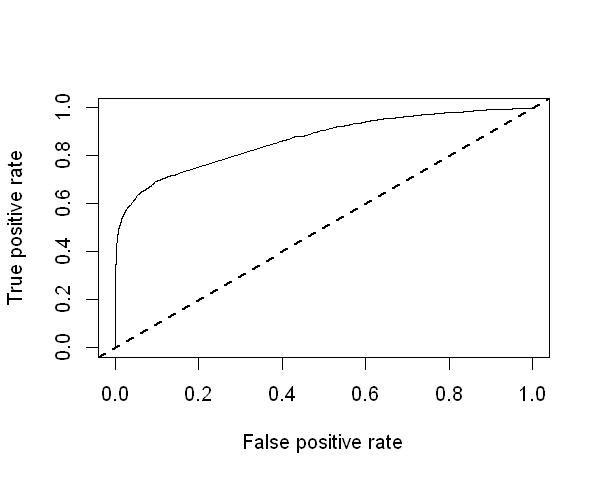

In [101]:
p = predict(toxic.glm, newdata = subset(val, select= c(8:85)), type = 'response')
pr = prediction(p, val$toxic)
prf = performance(pr, measure = 'tpr' , x.measure = 'fpr')
options(repr.plot.width=5, repr.plot.height=4)
plot(prf)
abline(0,1, lwd = 2, lty = 2)

In [102]:
auc = performance(pr, measure = 'auc')
str(auc)

Formal class 'performance' [package "ROCR"] with 6 slots
  ..@ x.name      : chr "None"
  ..@ y.name      : chr "Area under the ROC curve"
  ..@ alpha.name  : chr "none"
  ..@ x.values    : list()
  ..@ y.values    :List of 1
  .. ..$ : num 0.866
  ..@ alpha.values: list()


In [103]:
auc = auc@y.values[[1]]
auc

[1] 0.8660607

But wait it's not over yet, this is what makes this challenge much more interesting, we have got to still classify the text into 5 more labels i,e multi-label classification.
One way is to make predictions for each one individually as above and then calculate the Accuracy. That's a little tedious isn't it.

That's why R has introduced the mlr package through which we can achieve the output here for the multi-label classification.

Here two different approaches exist for multilabel classification.

Problem transformation methods try to transform the multilabel classification into binary or multiclass classification problems. 

Algorithm adaptation methods adapt multiclass algorithms so they can be applied directly to the problem.

# Final prediction using mlr

The first thing we have to do for multilabel classification in mlr is to get our data in the right format. We need a data.frame which consists of the features and a logical vector for each label which indicates if the label is present in the observation or not.

One way we can simpy do this is by passing a condition as below, which directly converts into 'logical' format i,e if > 0 then 'TRUE' else 'FALSE'.

We have to make sure before passing the condition that the variable consists only of binary(e.g 0 or 1).

In [49]:
#convert train targets to logical
tr$toxic <- tr$toxic > 0
tr$severe_toxic <- tr$severe_toxic > 0
tr$obscene <- tr$obscene > 0
tr$threat <- tr$threat > 0
tr$insult <- tr$insult > 0
tr$identity_hate <- tr$identity_hate > 0

In [50]:
#convert validation targets to logical
val$toxic <- val$toxic > 0
val$severe_toxic <- val$severe_toxic > 0
val$obscene <- val$obscene > 0
val$threat <- val$threat > 0
val$insult <- val$insult > 0
val$identity_hate <- val$identity_hate > 0

In [60]:
#removing the id's
tr <- tr[,-1]
val <- val[,-1]

In [61]:
#creating train and test labels
labels <- colnames(tr)[1:6]
ts_label <- colnames(val)[1:6]

In [59]:
library(mlr)

Loading required package: ParamHelpers
Warning message:
"replacing previous import 'BBmisc::isFALSE' by 'backports::isFALSE' when loading 'mlr'"

The 2nd step is to create a MultilabelTask like a normal ClassifTask. Instead of one target name we can specify a vector of targets which correspond to the names of logical variables in the data.frame.

In [62]:
#create tasks
comment.task = makeMultilabelTask(id = "multi", data = tr, target = labels)
tscomment.task = makeMultilabelTask(id = "multi", data = val, target = ts_label)

The next step is to Construct a learner

As mentioned above Multilabel classification in mlr can currently be done in two ways:

Algorithm adaptation methods: Treat the whole problem with a specific algorithm.

Problem transformation methods: Transform the problem, so that simple binary classification algorithms can be applied.


We'll be using the problem transformation method here and it inturn has the following methods:
    
    Binary relevance
    Classifier chains
    Nested stacking
    Dependent binary relevance
    Stacking

We shall use the Binary relevance method.

For generating a wrapped multilabel learner we first create a binary (or multiclass) classification learner with makeLearner. Afterwards apply a function like makeMultilabelBinaryRelevanceWrapper, makeMultilabelClassifierChainsWrapper, makeMultilabelNestedStackingWrapper, makeMultilabelDBRWrapper or makeMultilabelStackingWrapper on the learner to convert it to a learner that uses the respective problem transformation method.

In [63]:
lrn = makeLearner("classif.rpart", predict.type = "prob")
multilabel.lrn1 = makeMultilabelBinaryRelevanceWrapper(lrn)
multilabel.lrn2 = makeMultilabelNestedStackingWrapper(lrn)

The binary relevance problem transformation method consists of converting the multilabel problem to binary classification problems for each label and applies a simple binary classificator on these. By using this method, we assume that our labels are independent (i.e each one will be treated as a single, stand-alone target outcome, and will be classified without considering the remaining labels).

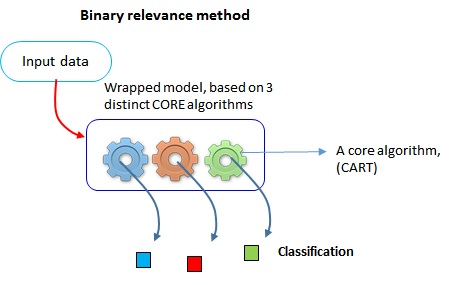

In [65]:
#train a model as usual with a multilabel learner and a multilabel task as input
mod = train(multilabel.lrn1, comment.task)

In [66]:
#Prediction can be done as usual in mlr with predict and by passing a trained model and either the task to the 
#task argument or some new data to the newdata argument
pred = predict(mod, task = tscomment.task)

For evaluating the overall performance of the learning algorithm we can do some resampling. 

Resampling strategies are usually used to assess the performance of a learning algorithm: The entire data set is (repeatedly) split into training sets D∗b and test sets D∖D∗b, b=1,…,B. The learner is trained on each training set, predictions are made on the corresponding test set (sometimes on the training set as well) and the performance measure S(D∗b,D∖D∗b) is calculated. Then the B individual performance values are aggregated, most often by calculating the mean. There exist various different resampling strategies, for example cross-validation and bootstrap, to mention just two popular approaches.

Resampling Figure
As usual you have to define a resampling strategy, either via makeResampleDesc or makeResampleInstance. After that you can run the resample function. Below the default measure Hamming loss is calculated.

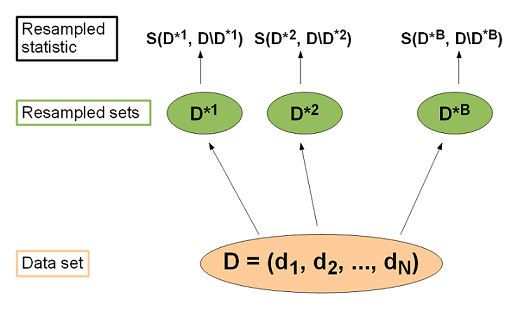

In [67]:
#resampling on the traning set
rdesc = makeResampleDesc(method = "CV", stratify = FALSE, iters = 3)
r = resample(learner = multilabel.lrn1, task = comment.task, resampling = rdesc,
measures = list(multilabel.hamloss), show.info = FALSE)

In [69]:
#resampling on the validation set
rdesc = makeResampleDesc(method = "CV", stratify = FALSE, iters = 3)
rtest = resample(learner = multilabel.lrn1, task = tscomment.task, resampling = rdesc,
measures = list(multilabel.hamloss), show.info = FALSE)

In [153]:
r

Resample Result
Task: multi
Learner: multilabel.classif.rpart
Aggr perf: multilabel.hamloss.test.mean=0.0248
Runtime: 54.0469

Finally let's see how our train set has perfomed.

Train set validation

In [68]:
head(getMultilabelBinaryPerformances(r$pred, measures = list(acc, mmce, auc)))

,acc.test.mean,mmce.test.mean,auc.test.mean
toxic,0.9351173,0.064882706,0.6988217
severe_toxic,0.9898895,0.010110505,0.4812150
obscene,0.9724781,0.027521882,0.8206144
threat,0.9970024,0.002997639,0.4720416
insult,0.9634643,0.036535690,0.7426157
identity_hate,0.9920724,0.007927555,0.6436202


Validation set performance

In [70]:
head(getMultilabelBinaryPerformances(rtest$pred, measures = list(acc, mmce, auc)))

,acc.test.mean,mmce.test.mean,auc.test.mean
toxic,0.9395886,0.060411412,0.7187400
severe_toxic,0.9901769,0.009823121,0.4608112
obscene,0.9745100,0.025489981,0.8257055
threat,0.9970076,0.002992370,0.4754887
insult,0.9642012,0.035798775,0.7409923
identity_hate,0.9918062,0.008193768,0.5931970


All right so we have finaly validated our validation set and it looks good, hence let's freeze our model here and proceed to pass on our actual test set and predict the values.

In [71]:
head(getPredictionResponse(pred))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
8,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
10,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
12,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
17,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [72]:
head(getPredictionProbabilities(pred))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,0.05674836,0.01011051,0.02020709,0.002997639,0.02560293,0.006143876
3,0.05674836,0.01011051,0.02020709,0.002997639,0.02560293,0.006143876
8,0.05674836,0.01011051,0.02020709,0.002997639,0.02560293,0.006143876
10,0.05674836,0.01011051,0.02020709,0.002997639,0.02560293,0.006143876
12,0.05674836,0.01011051,0.02020709,0.002997639,0.02560293,0.006143876
17,0.05674836,0.01011051,0.02020709,0.002997639,0.02560293,0.006143876


In [81]:
names(test_x)

[1] "id"            "toxic"         "severe_toxic"  "obscene"      
 [5] "threat"        "insult"        "identity_hate" "fuck"         
 [9] "self"          "your"          "shit"          "hate"         
[13] "hell"          "fat"           "shut"          "attack"       
[17] "stupid"        "moron"         "dispute"       "suck"         
[21] "cock"          "dick"          "bitch"         "free"         
[25] "reliable"      "fair"          "support"       "correct"      
[29] "happy"         "love"          "pretty"        "enjoy"        
[33] "speed"         "respect"       "accurate"      "help"         
[37] "fine"          "faith"         "lead"          "improve"      
[41] "bleach"        "hero"          "sex"           "nigger"       
[45] "judah"         "criminal"      "war"           "faggot"       
[49] "drink"         "die"           "bunk"          "troll"        
[53] "super"         "rab"           "ass"           "gay"          
[57] "murder"        "nl"            "colonial"      "occupation"   
[61] "arab"          "jew"           "ers"           "kill"         
[65] "moth"          "jerk"          "edit"          "make"         
[69] "page"          "please"        "remove"        "talk"         
[73] "thank"         "article"       "good"          "one"          
[77] "think"         "wikipedia"     "work"          "like"         
[81] "conjurer"      "source"        "time"          "people"

In [ ]:
test_xact = subset(test_x, select = -c(1:7))

In [80]:
#prediction on actual test data
predcomment = predict(mod, newdata = test_xact)

In [82]:
head(getPredictionResponse(predcomment))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
159572,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE
159573,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
159574,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
159575,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
159576,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
159577,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


A small rough work, let's see the first few texts in our test set and see if our model has predicted those accuarately.
From below we can see that the text is toxic with obscene but is that a insult too?

Making a second glance clearly it has some words which might hurt the feelings of someone, so it's cearly an insult too!! and for all these our model ha predicted 'TRUE'.

In [85]:
head(test$comment_text,1)

[1] "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

In [86]:
fncommentresultdf <- as.data.frame(getPredictionResponse(predcomment))

In [89]:
table(fncommentresultdf$toxic)


 FALSE   TRUE 
133381  19783 

In [92]:
#convert the TRUE/FALSE to 1'S AND 0'S.
fncommentresultdf$toxic <- ifelse(fncommentresultdf$toxic == 'TRUE',1,0)
fncommentresultdf$severe_toxic <- ifelse(fncommentresultdf$severe_toxic == 'TRUE',1,0)
fncommentresultdf$obscene <- ifelse(fncommentresultdf$obscene == 'TRUE',1,0)
fncommentresultdf$threat <- ifelse(fncommentresultdf$threat == 'TRUE',1,0)
fncommentresultdf$insult <- ifelse(fncommentresultdf$insult == 'TRUE',1,0)
fncommentresultdf$identity_hate <- ifelse(fncommentresultdf$identity_hate == 'TRUE',1,0)

In [95]:
#bind the output with the test id
fn.commentsubmission <- cbind(test$id,fncommentresultdf)

In [96]:
head(fn.commentsubmission)

,test$id,toxic,severe_toxic,obscene,threat,insult,identity_hate
159572,00001cee341fdb12,1,0,1,0,1,0
159573,0000247867823ef7,0,0,0,0,0,0
159574,00013b17ad220c46,0,0,0,0,0,0
159575,00017563c3f7919a,0,0,0,0,0,0
159576,00017695ad8997eb,0,0,0,0,0,0
159577,0001ea8717f6de06,0,0,0,0,0,0


In [99]:
names(fn.commentsubmission)[1] <- 'id'

In [114]:
#write the output submission file to csv
write.csv(fn.commentsubmission, file = 'finalcommetsubmission.csv')